<a href="https://colab.research.google.com/github/gaurav1234567897/gaurav1234567897/blob/main/CNN_Classification_of_buildings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Decision Models (Deep Learning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input,Dense,Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
% matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from glob import glob

In [ ]:
train_data_dir = "/content/drive/MyDrive/Images_Assignment_CNN_MG225/Training_Images"
img_height = 256
img_width = 256
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 251 images belonging to 2 classes.
Found 43 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
test_data = test_datagen.flow_from_directory('/content/drive/MyDrive/Images_Assignment_CNN_MG225/Testing_Images',batch_size=batch_size,class_mode='categorical',shuffle=False)

Found 126 images belonging to 2 classes.


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [17]:
# Data Exploration
image, label = train_generator.next()

In [18]:
glob(train_data_dir+'/*')

['/content/drive/MyDrive/Images_Assignment_CNN_MG225/Training_Images/Non_Built_Up',
 '/content/drive/MyDrive/Images_Assignment_CNN_MG225/Training_Images/Built_Up']

From here we can see class 0 is Built up and class 1 is non_built_up

In [19]:
train_generator.class_indices

{'Built_Up': 0, 'Non_Built_Up': 1}

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


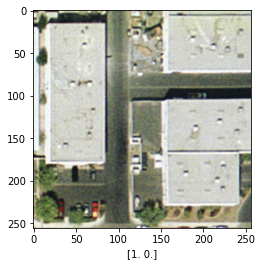

In [20]:
plt.imshow(image[0])
plt.xlabel(label[0]);

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


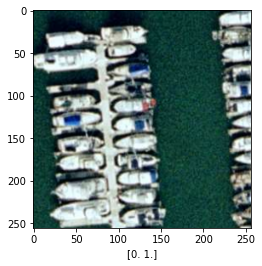

In [21]:
plt.imshow(image[2])
plt.xlabel(label[2]);

In [22]:
image, label = test_data.next()

Similarly for test data ,we can see class 0 is Built up and class 1 is non_built_up

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


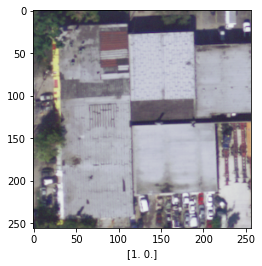

In [23]:
plt.imshow(image[0])
plt.xlabel(label[0]);

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


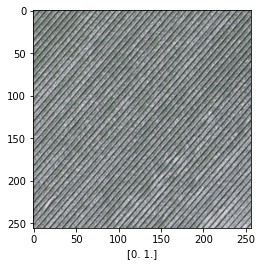

In [28]:
plt.imshow(image[31])
plt.xlabel(label[31]);

In [ ]:
# data is imbalanced hence balancing the data is necessary
count=np.bincount(train_generator.classes)
print("Class Built_up i.e., 0 count:",count[0])
print("Class Non_Built_up i.e., 1 count:",count[1])

Class Built_up i.e., 0 count: 60
Class Non_Built_up i.e., 1 count: 191


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import cohen_kappa_score
def evaluation_report(test_data):
  Y_pred = model.predict(test_data)
  y_pred = np.argmax(Y_pred, axis=1)
  print('Confusion Matrix')
  CM = confusion_matrix(test_data.classes, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=CM,
                                  display_labels=["Built_up","Non_Built_up"])
  disp.plot()
  plt.show()
  TN = CM[0][0]
  TP = CM[1][1]
  FP = CM[0][1]
  FN = CM[1][0]

  accuracy = (TN+TP)/(TN+TP+FP+FN)
  sensitivity = TP/(TP+FN)
  specificity = TN/(TN+FP)
  PPV = TP/(TP+FP)
  NPV = TN/(TN+FN)
  print('Accuracy score: ',accuracy)
  print('Sensitivity: ',sensitivity)
  print('Specificity: ',specificity)
  print('Positive prediction value: ',PPV)
  print('Negative prediction value: ',NPV)
  print('Kappa score: ',cohen_kappa_score(test_data.classes,y_pred))
  print('***************************************************')

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
            'balanced',
            classes = np.unique(train_generator.classes), 
            y = train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 2.091666666666667, 1: 0.6570680628272252}

### Used Transfer learning model VGG16 since normal convolution layer when used gives a very poor performance matrix and the results of the normal convolution layer performance matrix is shown at the last for reference 

In [ ]:
from tensorflow.keras.applications import VGG16
basic_conv = VGG16(weights='imagenet',include_top=False,input_shape=(img_width,img_height,3))
basic_conv.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

{ glorot_normal  ,  SGD }
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 500)               16384500  
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                25050     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (

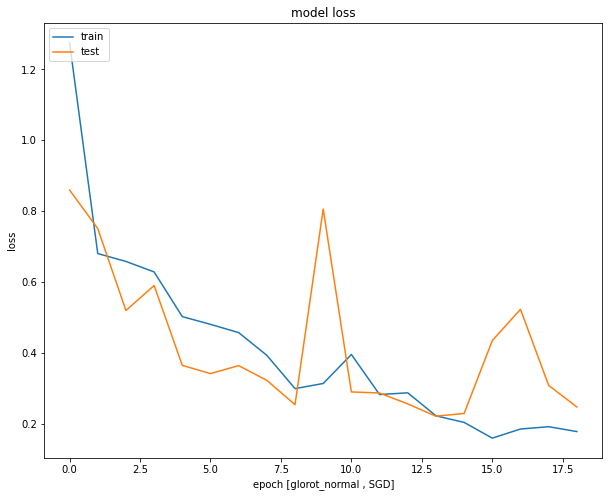

Confusion Matrix


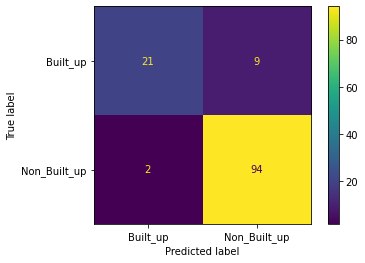

Accuracy score:  0.9126984126984127
Sensitivity:  0.9791666666666666
Specificity:  0.7
Positive prediction value:  0.912621359223301
Negative prediction value:  0.9130434782608695
Kappa score:  0.738391845979615
***************************************************
{ glorot_normal  ,  adam }
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 500)               16384500  
                                                                 
 dropout_2 (Dropout)         (None, 500)               0         
                                                                 
 dense_4 (Dense)           

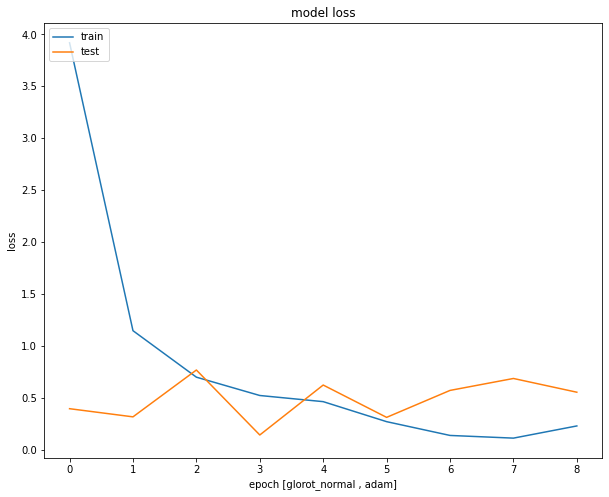

Confusion Matrix


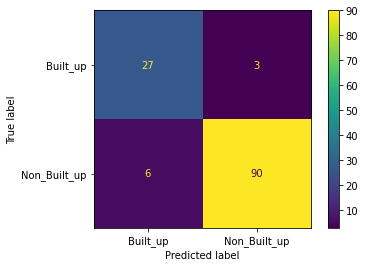

Accuracy score:  0.9285714285714286
Sensitivity:  0.9375
Specificity:  0.9
Positive prediction value:  0.967741935483871
Negative prediction value:  0.8181818181818182
Kappa score:  0.8096676737160121
***************************************************
{ glorot_normal  ,  Adagrad }
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 500)               16384500  
                                                                 
 dropout_4 (Dropout)         (None, 500)               0         
                                                                 
 dense_7 (Dense)             (None,

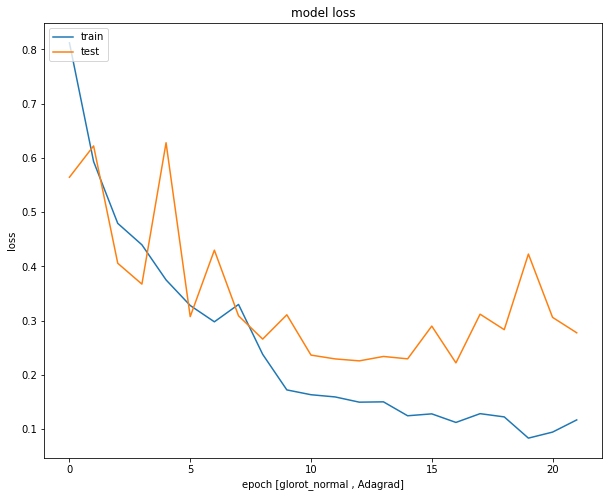

Confusion Matrix


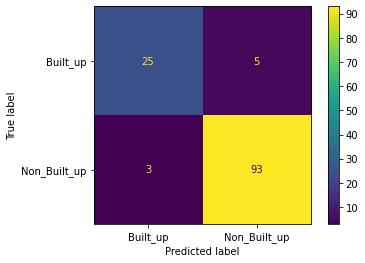

Accuracy score:  0.9365079365079365
Sensitivity:  0.96875
Specificity:  0.8333333333333334
Positive prediction value:  0.9489795918367347
Negative prediction value:  0.8928571428571429
Kappa score:  0.8208955223880596
***************************************************
{ glorot_normal  ,  RMSprop }
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_9 (Dense)             (None, 500)               16384500  
                                                                 
 dropout_6 (Dropout)         (None, 500)               0         
                                                                 
 dense_10 (Dense) 

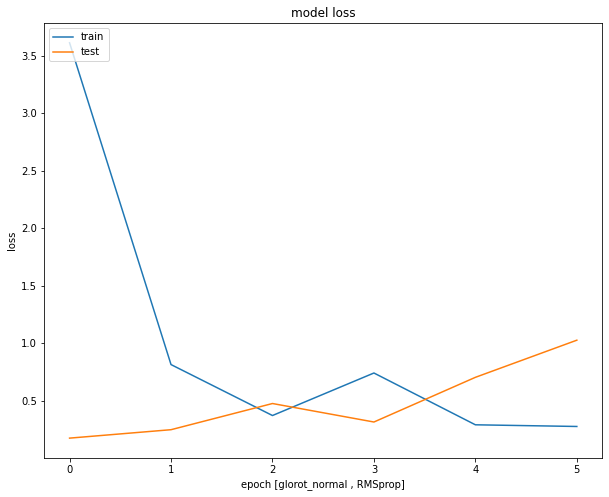

Confusion Matrix


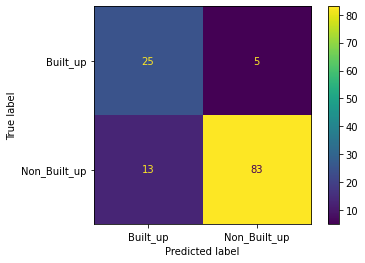

Accuracy score:  0.8571428571428571
Sensitivity:  0.8645833333333334
Specificity:  0.8333333333333334
Positive prediction value:  0.9431818181818182
Negative prediction value:  0.6578947368421053
Kappa score:  0.6393129770992366
***************************************************
{ glorot_uniform  ,  SGD }
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_12 (Dense)            (None, 500)               16384500  
                                                                 
 dropout_8 (Dropout)         (None, 500)               0         
                                                                 
 dense_13 

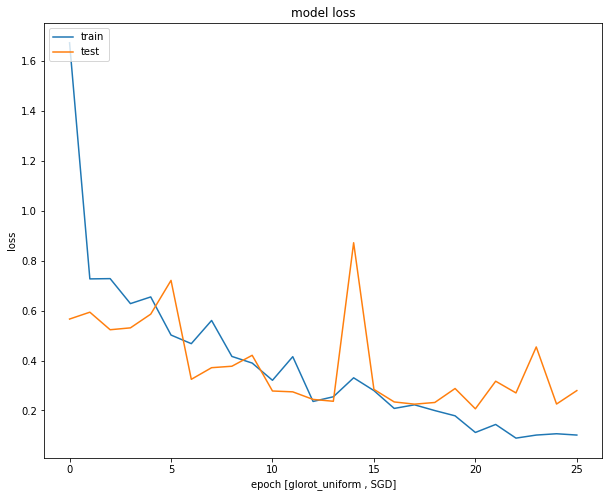

Confusion Matrix


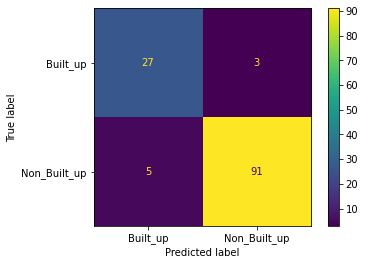

Accuracy score:  0.9365079365079365
Sensitivity:  0.9479166666666666
Specificity:  0.9
Positive prediction value:  0.9680851063829787
Negative prediction value:  0.84375
Kappa score:  0.8289205702647657
***************************************************
{ glorot_uniform  ,  adam }
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dense_15 (Dense)            (None, 500)               16384500  
                                                                 
 dropout_10 (Dropout)        (None, 500)               0         
                                                                 
 dense_16 (Dense)            (None,

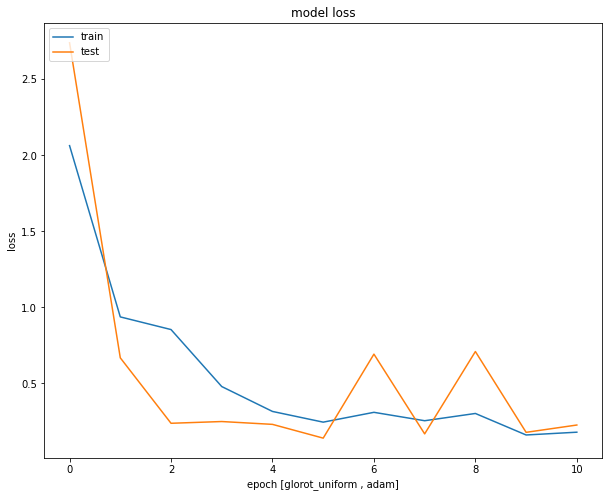

Confusion Matrix


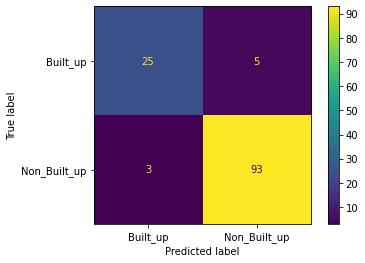

Accuracy score:  0.9365079365079365
Sensitivity:  0.96875
Specificity:  0.8333333333333334
Positive prediction value:  0.9489795918367347
Negative prediction value:  0.8928571428571429
Kappa score:  0.8208955223880596
***************************************************
{ glorot_uniform  ,  Adagrad }
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 32768)             0         
                                                                 
 dense_18 (Dense)            (None, 500)               16384500  
                                                                 
 dropout_12 (Dropout)        (None, 500)               0         
                                                                 
 dense_19 (Dense)

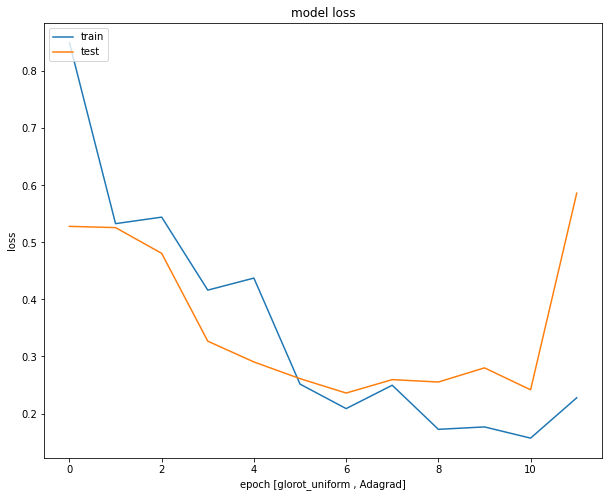

Confusion Matrix


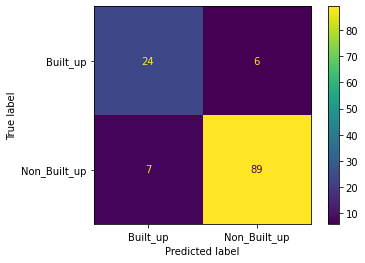

Accuracy score:  0.8968253968253969
Sensitivity:  0.9270833333333334
Specificity:  0.8
Positive prediction value:  0.9368421052631579
Negative prediction value:  0.7741935483870968
Kappa score:  0.7188465499485067
***************************************************
{ glorot_uniform  ,  RMSprop }
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 32768)             0         
                                                                 
 dense_21 (Dense)            (None, 500)               16384500  
                                                                 
 dropout_14 (Dropout)        (None, 500)               0         
                                                                 
 dense_22 (Dense)    

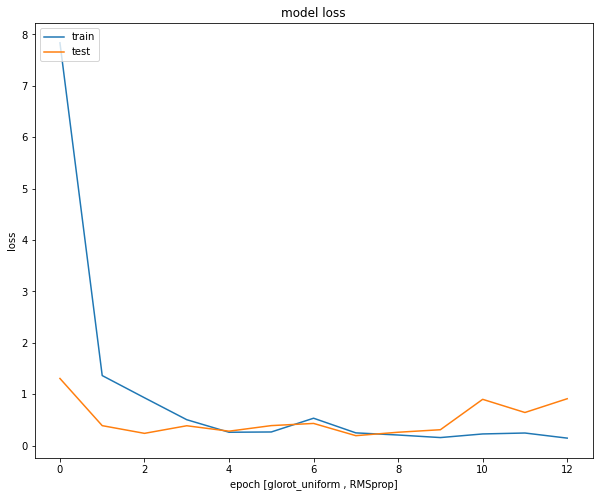

Confusion Matrix


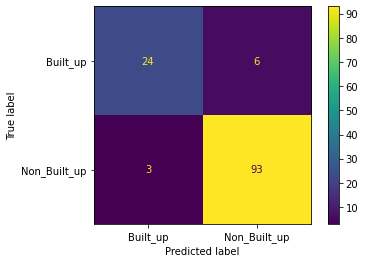

Accuracy score:  0.9285714285714286
Sensitivity:  0.96875
Specificity:  0.8
Positive prediction value:  0.9393939393939394
Negative prediction value:  0.8888888888888888
Kappa score:  0.7961165048543689
***************************************************
{ he_normal  ,  SGD }
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 32768)             0         
                                                                 
 dense_24 (Dense)            (None, 500)               16384500  
                                                                 
 dropout_16 (Dropout)        (None, 500)               0         
                                                                 
 dense_25 (Dense)            (None, 50)  

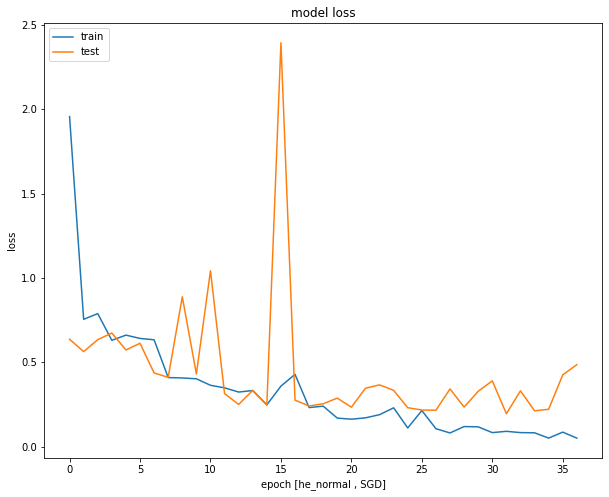

Confusion Matrix


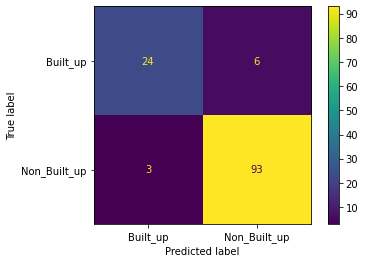

Accuracy score:  0.9285714285714286
Sensitivity:  0.96875
Specificity:  0.8
Positive prediction value:  0.9393939393939394
Negative prediction value:  0.8888888888888888
Kappa score:  0.7961165048543689
***************************************************
{ he_normal  ,  adam }
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 32768)             0         
                                                                 
 dense_27 (Dense)            (None, 500)               16384500  
                                                                 
 dropout_18 (Dropout)        (None, 500)               0         
                                                                 
 dense_28 (Dense)            (None, 50) 

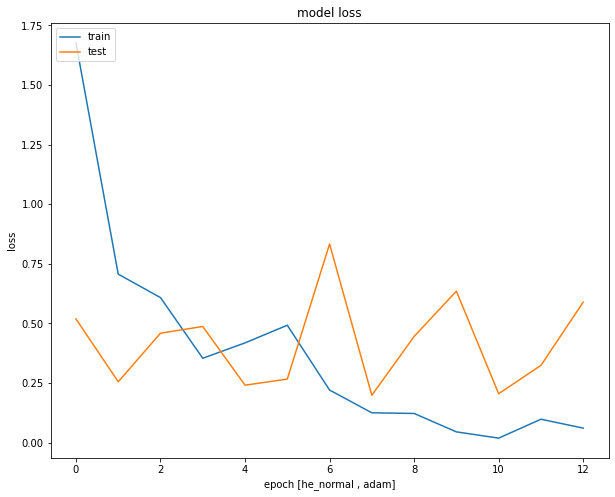

Confusion Matrix


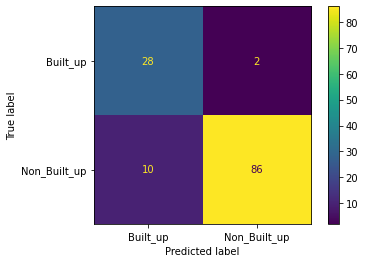

Accuracy score:  0.9047619047619048
Sensitivity:  0.8958333333333334
Specificity:  0.9333333333333333
Positive prediction value:  0.9772727272727273
Negative prediction value:  0.7368421052631579
Kappa score:  0.7595419847328244
***************************************************
{ he_normal  ,  Adagrad }
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 32768)             0         
                                                                 
 dense_30 (Dense)            (None, 500)               16384500  
                                                                 
 dropout_20 (Dropout)        (None, 500)               0         
                                                                 
 dense_31 

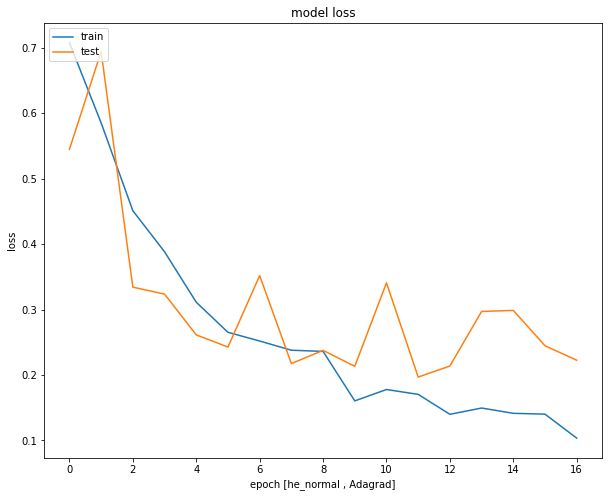

Confusion Matrix


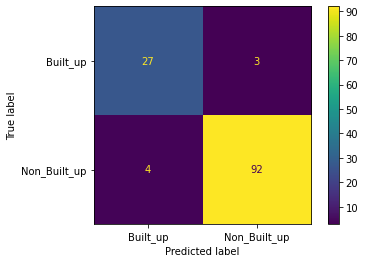

Accuracy score:  0.9444444444444444
Sensitivity:  0.9583333333333334
Specificity:  0.9
Positive prediction value:  0.968421052631579
Negative prediction value:  0.8709677419354839
Kappa score:  0.8486096807415036
***************************************************
{ he_normal  ,  RMSprop }
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_11 (Flatten)        (None, 32768)             0         
                                                                 
 dense_33 (Dense)            (None, 500)               16384500  
                                                                 
 dropout_22 (Dropout)        (None, 500)               0         
                                                                 
 dense_34 (Dense)         

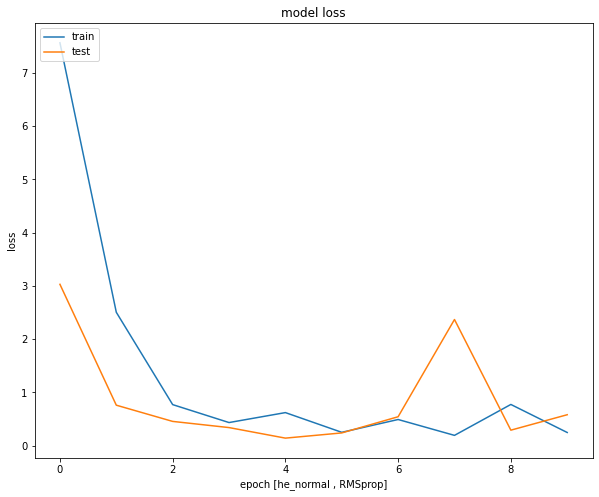

Confusion Matrix


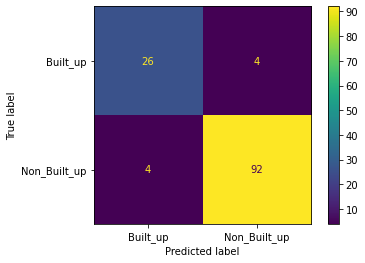

Accuracy score:  0.9365079365079365
Sensitivity:  0.9583333333333334
Specificity:  0.8666666666666667
Positive prediction value:  0.9583333333333334
Negative prediction value:  0.8666666666666667
Kappa score:  0.825
***************************************************
{ he_uniform  ,  SGD }
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_12 (Flatten)        (None, 32768)             0         
                                                                 
 dense_36 (Dense)            (None, 500)               16384500  
                                                                 
 dropout_24 (Dropout)        (None, 500)               0         
                                                                 
 dense_37 (Dense)         

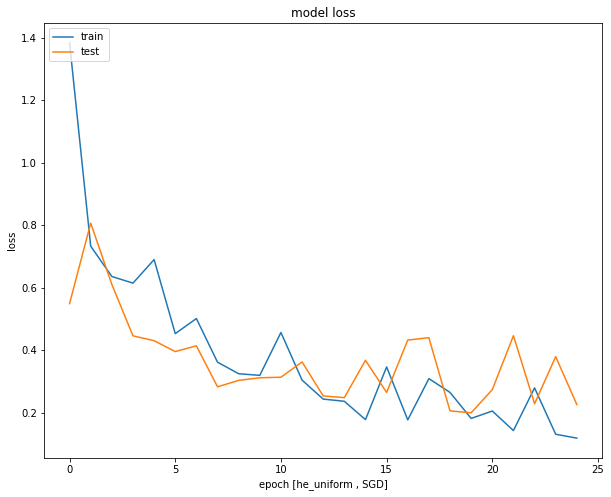

Confusion Matrix


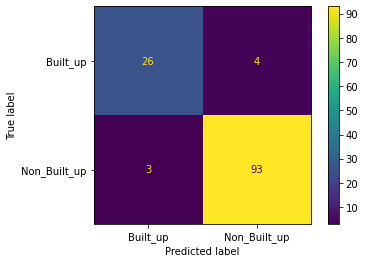

Accuracy score:  0.9444444444444444
Sensitivity:  0.96875
Specificity:  0.8666666666666667
Positive prediction value:  0.9587628865979382
Negative prediction value:  0.896551724137931
Kappa score:  0.845100105374078
***************************************************
{ he_uniform  ,  adam }
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_13 (Flatten)        (None, 32768)             0         
                                                                 
 dense_39 (Dense)            (None, 500)               16384500  
                                                                 
 dropout_26 (Dropout)        (None, 500)               0         
                                                                 
 dense_40 (Dense)        

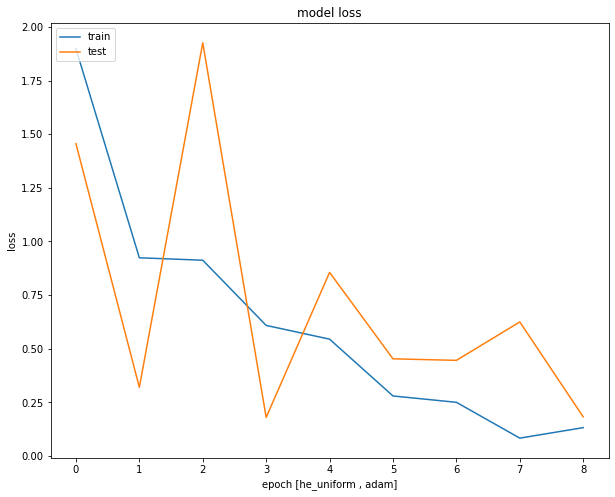

Confusion Matrix


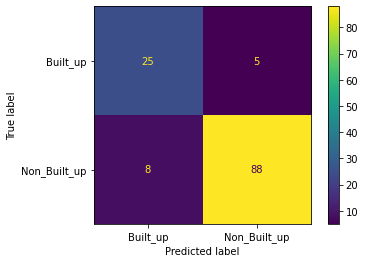

Accuracy score:  0.8968253968253969
Sensitivity:  0.9166666666666666
Specificity:  0.8333333333333334
Positive prediction value:  0.946236559139785
Negative prediction value:  0.7575757575757576
Kappa score:  0.7250755287009063
***************************************************
{ he_uniform  ,  Adagrad }
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_14 (Flatten)        (None, 32768)             0         
                                                                 
 dense_42 (Dense)            (None, 500)               16384500  
                                                                 
 dropout_28 (Dropout)        (None, 500)               0         
                                                                 
 dense_43 

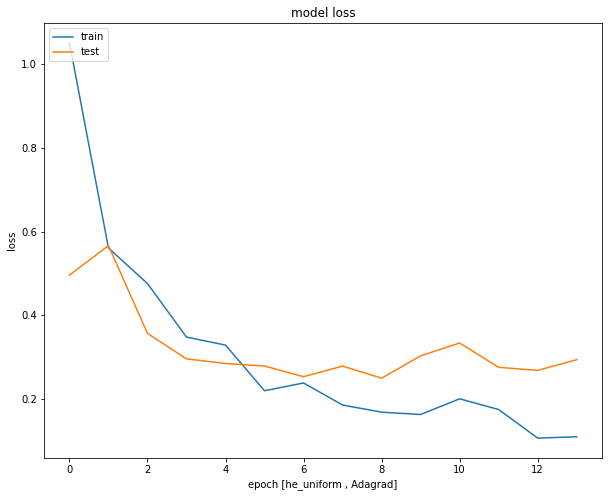

Confusion Matrix


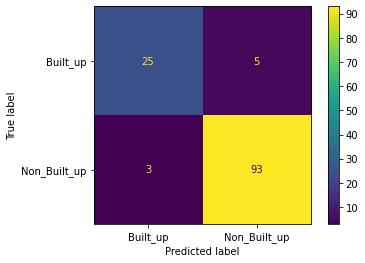

Accuracy score:  0.9365079365079365
Sensitivity:  0.96875
Specificity:  0.8333333333333334
Positive prediction value:  0.9489795918367347
Negative prediction value:  0.8928571428571429
Kappa score:  0.8208955223880596
***************************************************
{ he_uniform  ,  RMSprop }
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_15 (Flatten)        (None, 32768)             0         
                                                                 
 dense_45 (Dense)            (None, 500)               16384500  
                                                                 
 dropout_30 (Dropout)        (None, 500)               0         
                                                                 
 dense_46 (Dense)   

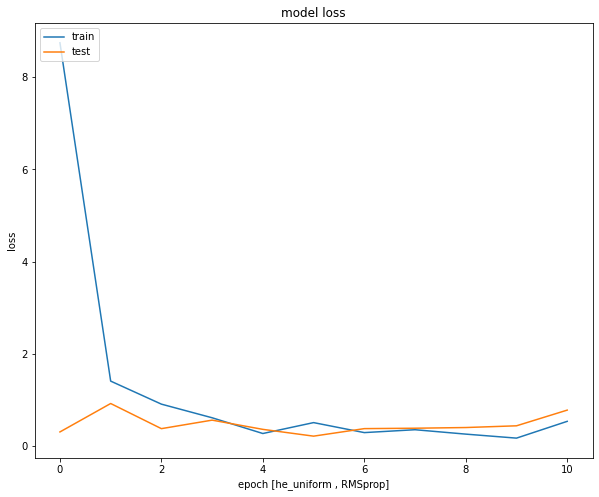

Confusion Matrix


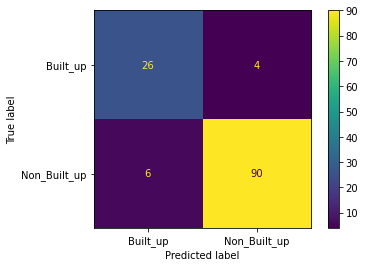

Accuracy score:  0.9206349206349206
Sensitivity:  0.9375
Specificity:  0.8666666666666667
Positive prediction value:  0.9574468085106383
Negative prediction value:  0.8125
Kappa score:  0.7861507128309573
***************************************************


In [ ]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
for layer in basic_conv.layers:
  layer.trainable = False


for i in ["glorot_normal","glorot_uniform","he_normal","he_uniform"]:
  for j in ["SGD","adam","Adagrad","RMSprop"]:
  
    # Making the model
    print('{',i,' , ',j,'}')
    kernel_ini = i
    model = Sequential()
    model.add(basic_conv)

    # model.add(Input(shape=(img_height,img_width,3)))
    # model.add(layers.Conv2D(16,5,activation='relu',kernel_initializer=kernel_ini))
    # model.add(layers.MaxPooling2D((2,2)))
    # model.add(layers.Conv2D(48,3,padding='same',activation='relu',kernel_initializer=kernel_ini))
    # model.add(layers.MaxPooling2D((2,2)))
    # model.add(layers.Conv2D(96,3,padding='same',activation='relu',kernel_initializer=kernel_ini))
    # model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(Dense(500,activation='relu',kernel_initializer=kernel_ini))
    model.add(layers.Dropout(0.5))
    model.add(Dense(50,activation='relu',kernel_initializer=kernel_ini))
    model.add(layers.Dropout(0.2))
    model.add(Dense(2,activation='softmax',kernel_initializer=kernel_ini))
    model.summary()

    # Compiling and fitting the model
    model.compile(optimizer = j,
              loss='categorical_crossentropy',
              metrics=METRICS)
    es = keras.callbacks.EarlyStopping(
        monitor='val_loss',mode= 'min', patience=5, verbose=1,restore_best_weights=True
        )
    history = model.fit(
        train_generator,
        steps_per_epoch = math.ceil(train_generator.samples / batch_size),
        validation_data = validation_generator,
        validation_steps = math.ceil(validation_generator.samples / batch_size),
        class_weight=class_weights,
        epochs = 100, callbacks=[es])
    # summarize history for loss
    plt.figure(figsize = (10,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch'+' ['+i+' , '+j+']')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    evaluation_report(test_data)

Making model with Normal Convolution layer CNN without using VGG16

{ glorot_normal  ,  adam }
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 126, 126, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 126, 126, 48)      6960      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 63, 63, 48)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 63, 63, 96)        41568     
                                                                 
 max_pooling2d_8 (MaxPooli

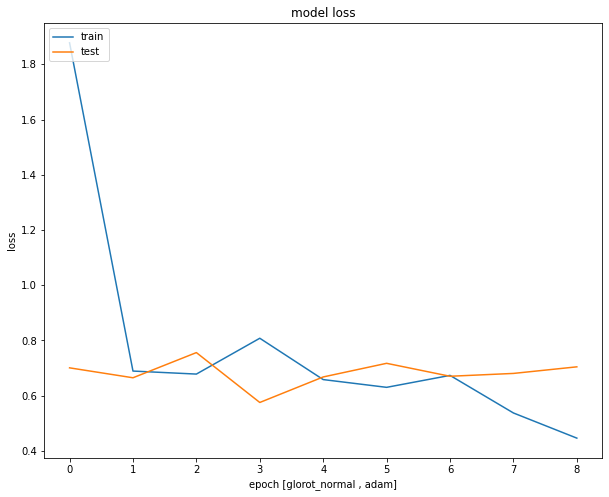

Confusion Matrix


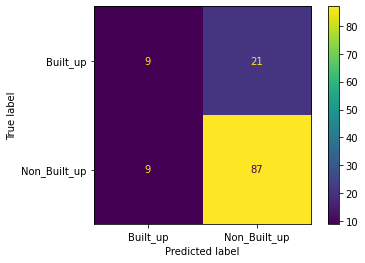

Accuracy score:  0.7619047619047619
Sensitivity:  0.90625
Specificity:  0.3
Positive prediction value:  0.8055555555555556
Negative prediction value:  0.5
Kappa score:  0.23913043478260876
***************************************************


In [16]:
# Making the model
i = "glorot_normal"
j = "adam"
print('{',i,' , ',j,'}')
kernel_ini = i
model = Sequential()
model.add(Input(shape=(img_height,img_width,3)))
model.add(layers.Conv2D(16,5,activation='relu',kernel_initializer=kernel_ini))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(48,3,padding='same',activation='relu',kernel_initializer=kernel_ini))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(96,3,padding='same',activation='relu',kernel_initializer=kernel_ini))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(Dense(500,activation='relu',kernel_initializer=kernel_ini))
model.add(layers.Dropout(0.5))
model.add(Dense(50,activation='relu',kernel_initializer=kernel_ini))
model.add(layers.Dropout(0.2))
model.add(Dense(2,activation='softmax',kernel_initializer=kernel_ini))
model.summary()

# Compiling and fitting the model
model.compile(optimizer = j,
          loss='categorical_crossentropy',
          metrics=METRICS)
es = keras.callbacks.EarlyStopping(
    monitor='val_loss',mode= 'min', patience=5, verbose=1,restore_best_weights=True
    )
history = model.fit(
    train_generator,
    steps_per_epoch = math.ceil(train_generator.samples / batch_size),
    validation_data = validation_generator,
    validation_steps = math.ceil(validation_generator.samples / batch_size),
    class_weight=class_weights,
    epochs = 100, callbacks=[es])
# summarize history for loss
plt.figure(figsize = (10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch'+' ['+i+' , '+j+']')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
evaluation_report(test_data)